Torch implementation of AA - When done should be moved to a .py file to allow easy implementation, or alternatively allow saving of model parameters

In [2]:
import torch
import numpy as np

from helpers.data import X
from helpers.callbacks import earlyStop
from helpers.losses import frobeniusLoss

In [5]:
class torchAA(torch.nn.Module):
    def __init__(self, X, rank):
        super(torchAA, self).__init__()
        
        #Shape of Matrix for reproduction
        n_row, n_col = X.shape
        self.X = torch.tensor(X)
        
        #softmax layer
        self.softmax = torch.nn.Softmax(dim = 0)
        
        #Initialization of Tensors/Matrices S and C with size Col x Rank and Rank x Col
        # NxM (X) * MxD (C) = NxD (XC)
        # NxD (XC) * DxM (S) = NxM (XCS)
        
        self.C = torch.nn.Parameter(torch.rand(n_col, rank, requires_grad=True))
        self.S = torch.nn.Parameter(torch.rand(rank, n_col, requires_grad=True))
        
        
    def forward(self):
        #Implementation of AA - F(C, S) = ||X - XCS||^2
        
        #first matrix Multiplication with softmax
        self.XC = torch.matmul(self.X.double(),
                               self.softmax(self.C.double()))
        
        #Second matrix multiplication with softmax
        self.XCS = torch.matmul(self.XC.double(),
                                self.softmax(self.S.double()))
        
        x = self.X - self.XCS
        
        return x

In [11]:
aa = torchAA(X, 10)

#optimizer for modifying learning rate, ADAM chosen because of https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
optimizer = torch.optim.Adam(aa.parameters(), lr=0.3)

#early stopping
es = earlyStop(patience=5, offset=-0.1)

running_loss = []

while (not es.trigger()):
    #zero optimizer gradient
    optimizer.zero_grad()

    #forward
    output = aa()
    
    #backward
    loss = frobeniusLoss()
    loss = loss.forward(output)
    loss.backward()
    
    #Update A and B
    optimizer.step()
    
    #append loss for graphing
    running_loss.append(loss.item())
    
    #count with early stopping
    es.count(loss.item())
    
    #print loss
    print(f"epoch: {len(running_loss)}, Loss: {loss.item()}", end='\r')

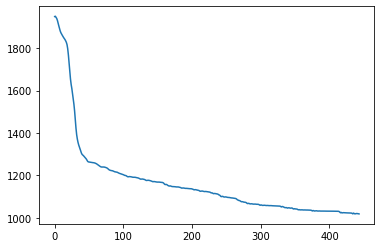

In [12]:
import matplotlib.pyplot as plt

plt.plot(running_loss)
plt.show()